### Experiments with training spectral bias

Imports

In [27]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader, TensorDataset, random_split
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import random
import torch.nn as nn
import torch.optim as optim
import heapq
import os
from datetime import datetime
import argparse
import torch.nn.functional as F

Set save to True if you want to save plots

In [28]:
save = False

Only for python script: uncomment if running on cluster

In [29]:
# These are both placeholders
num_epochs = 1000
model_name = 'f0'

In [30]:
# # Parse command-line arguments
# parser = argparse.ArgumentParser(description='Train a neural network model')
# parser.add_argument('--epochs', type=int, default=1000, help='Number of training epochs')
# parser.add_argument('--model_name', type=str, default='model', help='Name of the saved model')
# args = parser.parse_args()

# # Use the parsed arguments
# num_epochs = args.epochs
# model_name = args.model_name

Check if CUDA is available

In [31]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [32]:
# For reproducibility
seed = 42

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed)

**Simplified function generation**

In [33]:
def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
    x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
    functions = []
    derivatives = []
    
    for _ in range(num_samples):
        num_freqs = torch.randint(min_freq, max_freq * 2, (1,)).item()
        amplitudes = torch.rand(num_freqs * 2)  # Double the number of amplitudes
        frequencies = torch.randint(min_freq, max_freq + 1, (num_freqs,)).float()
        phases = torch.rand(num_freqs * 2) * 2 * np.pi  # Double the number of phases
        
        y = sum(a * torch.sin(f * x + p) for a, f, p in zip(amplitudes[:num_freqs], frequencies, phases[:num_freqs])) + \
            sum(a * torch.cos(f * x + p) for a, f, p in zip(amplitudes[num_freqs:], frequencies, phases[num_freqs:]))
        
        dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
        functions.append(y.detach().numpy())
        derivatives.append(dy_dx.detach().numpy())
    
    return np.array(functions), np.array(derivatives)

In [34]:
# def generate_freq_dataset(num_samples, num_points, min_freq, max_freq):
#     x = torch.linspace(0, 2 * np.pi, num_points, requires_grad=True)
#     functions = []
#     derivatives = []
    
#     for _ in range(num_samples):
#         num_freqs = torch.randint(min_freq, max_freq + 1, (1,)).item()
#         amplitudes = torch.rand(num_freqs) * 2 - 1  # Uniform distribution between -1 and 1
#         frequencies = torch.rand(num_freqs) * (max_freq - min_freq) + min_freq
#         phases = torch.rand(num_freqs) * 2 * np.pi
        
#         y = torch.zeros_like(x)
#         for a, f, p in zip(amplitudes, frequencies, phases):
#             y += a * torch.sin(f * x + p)
#             y += a * torch.cos(f * x + p)
        
#         dy_dx = torch.autograd.grad(y, x, grad_outputs=torch.ones_like(y), create_graph=True)[0]
        
#         functions.append(y.detach().numpy())
#         derivatives.append(dy_dx.detach().numpy())
    
#     return np.array(functions), np.array(derivatives)


## Generate datasets

In [35]:
num_samples = 500
num_points = 1000
batch_size = 32

low_freq_functions, low_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 5)
general_freq_functions, general_freq_derivatives = generate_freq_dataset(num_samples, num_points, 1, 10)
high_freq_functions, high_freq_derivatives = generate_freq_dataset(num_samples, num_points, 5, 10)

low_freq_dataset = TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives))
general_freq_dataset = TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives))
high_freq_dataset = TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives))

low_freq_dataloader = DataLoader(TensorDataset(torch.tensor(low_freq_functions), torch.tensor(low_freq_derivatives)), batch_size=batch_size, shuffle=True)
high_freq_dataloader = DataLoader(TensorDataset(torch.tensor(high_freq_functions), torch.tensor(high_freq_derivatives)), batch_size=batch_size, shuffle=True)
general_freq_dataloader = DataLoader(TensorDataset(torch.tensor(general_freq_functions), torch.tensor(general_freq_derivatives)), batch_size=batch_size, shuffle=True)

In [36]:
total_size = len(low_freq_dataset)
train_size = int(0.8 * total_size)
test_size = total_size - train_size
generator = torch.Generator().manual_seed(seed)

# low freq
train_dataset_l, test_dataset_l = random_split(low_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_l = DataLoader(train_dataset_l, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_l = DataLoader(test_dataset_l, batch_size=32, shuffle=False, drop_last=True)

# general freq
train_dataset_g, test_dataset_g = random_split(general_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_g = DataLoader(train_dataset_g, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_g = DataLoader(test_dataset_g, batch_size=32, shuffle=False, drop_last=True)

# high freq
train_dataset_h, test_dataset_h = random_split(high_freq_dataset, [train_size, test_size], generator=generator)
train_dataloader_h = DataLoader(train_dataset_h, batch_size=32, shuffle=True, drop_last=True)
test_dataloader_h = DataLoader(test_dataset_h, batch_size=32, shuffle=False, drop_last=True)


## Plot random function from one of the datasets

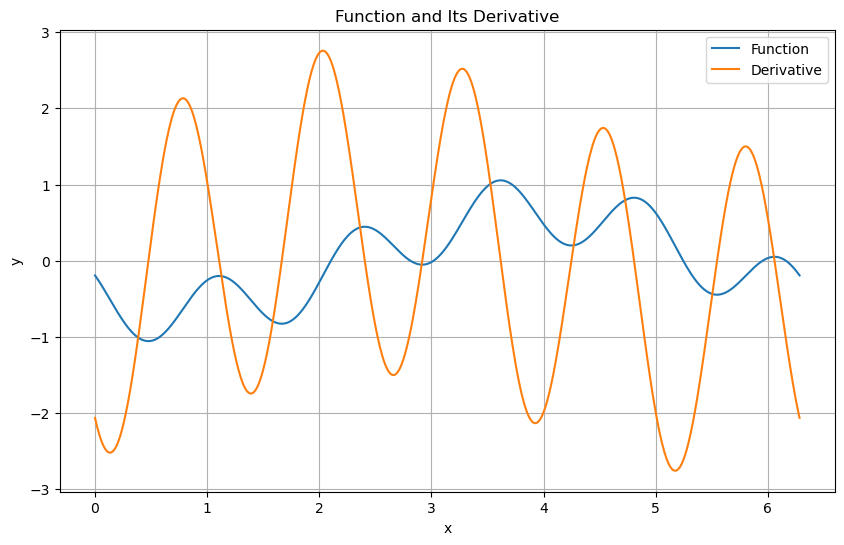

In [37]:
a = np.random.randint(32)

fun, deriv = next(iter(low_freq_dataloader))

first_function = fun[a]
first_derivative = deriv[a]

# Generate x values corresponding to the function inputs
x_values = np.linspace(0, 2 * np.pi, 1000)

# Plotting the function and its derivative
plt.figure(figsize=(10, 6))
plt.plot(x_values, first_function, label='Function')
plt.plot(x_values, first_derivative, label='Derivative')
plt.title('Function and Its Derivative')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
# Save datasets
# torch.save(general_freq_dataset, 'datasets/general_freq_dataset.pt')
# torch.save(low_freq_dataset, 'datasets/low_freq_dataset.pt')
# torch.save(high_freq_dataset, 'datasets/high_freq_dataset.pt')

Stopped here

## Model architecture

This CNN uses 3 layers, each with kernel size 3

In [39]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv1d(64, 1, kernel_size=3, padding=1)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.conv3(x)
        return x

In [40]:
f0 = SimpleCNN()
criterion = nn.MSELoss()

## Miscellaneous plotting functions

In [41]:
def plot_losses(train_losses, test_losses, save_dir='plots', filename=None, save=False):
    if not train_losses:
        return
    
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    current_date = datetime.now().strftime("%m-%d")
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, linestyle='-', color='b', label='Training Loss')
    plt.plot(epochs, test_losses, linestyle='-', label='Test Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')  # Set the y-axis to logarithmic scale
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"
    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)    
    plt.show()

In [42]:
def plot_output(model1, dataset, order=None, save_dir='plots', filename=None, save=False): 
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    
    current_date = datetime.now().strftime("%m-%d")
    model1.eval()  # Set the model to evaluation mode

    train_dataloader_viz = get_random_function(dataset, shuffle=True)
    # Get a random sample from the dataloader
    dataiter = iter(train_dataloader_viz)
    function, true_derivative = next(dataiter)

    # Reshape the input for the model
    function = function.unsqueeze(1)  # Add channel dimension

    # Make prediction
    with torch.no_grad():
        if order == 1 or order == 2:
            predicted_derivative = model1(function)
        
        if order == 'rollout':
            predicted_derivative = model1(function)
            predicted_derivative = model1(predicted_derivative)

    # Convert tensors to numpy arrays for plotting
    x = torch.linspace(0, 2*torch.pi, 1000).numpy()
    function = function.squeeze().numpy()

    predicted_derivative = predicted_derivative.squeeze().numpy()

    true_derivative = true_derivative.squeeze().numpy()

    # Plot the results
    plt.figure(figsize=(12, 6))

    plt.plot(x, function, label='Original Function', color='blue')
    if order == 1:
        plt.plot(x, true_derivative, label=f'True {order}st derivative')

    plt.plot(x[10:-10], predicted_derivative[10:-10], label=f'Predicted {order}nd Derivative', linestyle='--')

    plt.title('Function, True Derivatives, and Predicted Derivatives')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.grid(True)
    filename = f"{filename}_{current_date}.png"

    save_path = os.path.join(save_dir, filename)
    if save:
        plt.savefig(save_path)  
    plt.show()

In [43]:
def get_random_function(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=1, shuffle=shuffle)

## Function to train model

In [44]:
train_losses, test_losses = [], []

def model_training(model, train_dataloader, test_dataloader, num_epochs,\
    split_freq=None, filename=None, save=None, order=None):
    train_losses = []
    test_losses = []

    low_freq_nmses = []
    general_freq_nmses = []
    high_freq_nmses = []
    epoch_list = []

    lr = 1e-3

    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        test_loss = 0.0

        if epoch % split_freq == 0:
            l, g, h = print_and_store_metrics(model)
            low_freq_nmses.append(l)
            general_freq_nmses.append(g)
            high_freq_nmses.append(h)
            epoch_list.append(epoch)

        for batch_functions, batch_derivatives in train_dataloader:
            batch_functions = batch_functions.unsqueeze(1)
            batch_derivatives = batch_derivatives.unsqueeze(1)

            outputs = model(batch_functions)
            loss = criterion(outputs, batch_derivatives)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        model.eval()
        with torch.no_grad():
            for b_test_functions, b_test_derivatives in test_dataloader:
                b_test_functions = b_test_functions.unsqueeze(1)
                b_test_derivatives = b_test_derivatives.unsqueeze(1)

                test_outputs = model(b_test_functions)
                batch_test_loss = criterion(test_outputs, b_test_derivatives)

                test_loss += batch_test_loss.item()

        test_loss /= len(test_dataloader)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

    print(f"Training finished for {order}st derivative")

    plt.figure(figsize=(10, 6))
    plt.plot(epoch_list, low_freq_nmses, label='Low freq NMSE')
    plt.plot(epoch_list, general_freq_nmses, label='General freq NMSE')
    plt.plot(epoch_list, high_freq_nmses, label='High freq NMSE')

    # Adding labels and title
    plt.xlabel('Epoch')
    plt.ylabel('NMSE')
    plt.title('NMSEs of different frequencies during training')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.show()
    if save:
        plt.savefig(filename)  

    return train_losses, test_losses

## Metric functions

In [45]:
def compute_mse(dataloader, model):
    """
    Takes in a dataloader and a model to compute MSE.
    """

    model.eval()
    all_outputs = []
    all_targets = []

    for function, deriv in dataloader:
        function = function.unsqueeze(1)
        deriv = deriv.unsqueeze(1)

        # Compute model output
        model_output = model(function)
        all_targets.append(deriv)

        # Collect outputs
        all_outputs.append(model_output)

    # Concatenate all collected outputs and targets
    all_outputs = torch.cat(all_outputs, dim=0)
    all_targets = torch.cat(all_targets, dim=0)

    # Compute MSE
    mse = torch.mean((all_targets - all_outputs) ** 2)
    nmse = mse / torch.mean(all_targets ** 2)

    return mse.item(), nmse.item()

criterion = torch.nn.MSELoss()

In [46]:
def print_and_store_metrics(f0):
    return compute_mse(train_dataloader_l, f0)[1], compute_mse(train_dataloader_g, f0)[1], compute_mse(train_dataloader_h, f0)[1]

In [47]:
def print_metrics(model):
    print(f"NMSE over low freq test functions: {compute_mse(test_dataloader_l, model)[1]}")
    print(f"NMSE over general freq test functions: {compute_mse(test_dataloader_g, model)[1]}")
    print(f"NMSE over high freq test functions: {compute_mse(test_dataloader_h, model)[1]}")



## Create models

In [48]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs) - 1:
                x = self.relu(conv(x))
            else:
                x = conv(x)
        return x

In [49]:
set_seed(seed)
L3ModelK3 = SimpleCNN(n_layers=3, kernel_size=3)

In [50]:
# train_losses, test_losses = model_training(L3ModelK3, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

## Plot results

Low frequency output

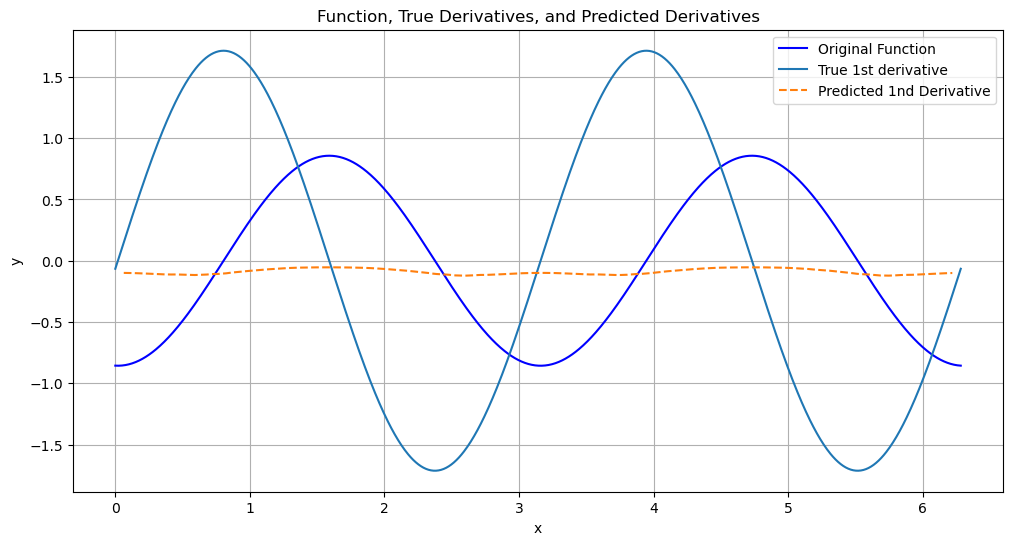

In [51]:
plot_output(L3ModelK3, dataset=train_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

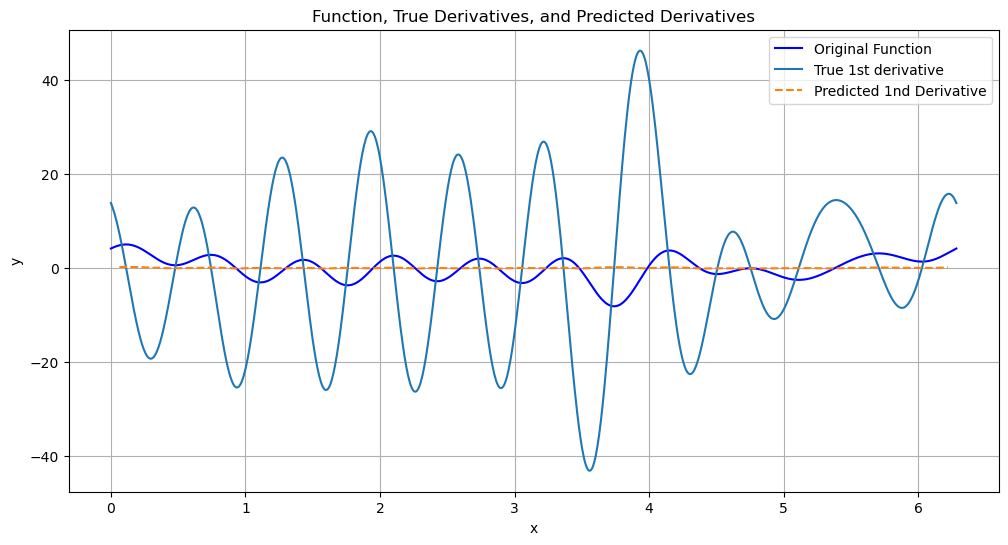

In [52]:
plot_output(L3ModelK3, dataset=train_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

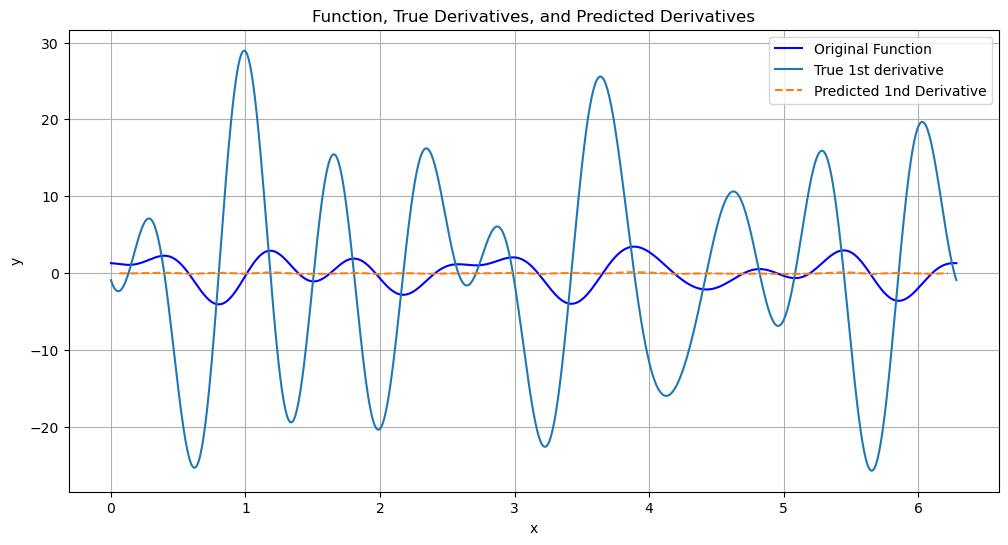

In [53]:
plot_output(L3ModelK3, dataset=train_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

In [55]:
print_metrics(L3ModelK3)

NMSE over low freq test functions: 0.9994839429855347
NMSE over general freq test functions: 0.9993737936019897
NMSE over high freq test functions: 0.9993956089019775


In [56]:
print(L3ModelK3)

SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (2): Conv1d(64, 1, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


**3 layer model with kernel size 9**

In [57]:
set_seed(seed)
L3ModelK9 = SimpleCNN(n_layers=3, kernel_size=9)

In [58]:
# train_losses, test_losses = model_training(L3ModelK9, train_dataloader_g, test_dataloader_g,\
#     num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
#     save=save, order='first')
# plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

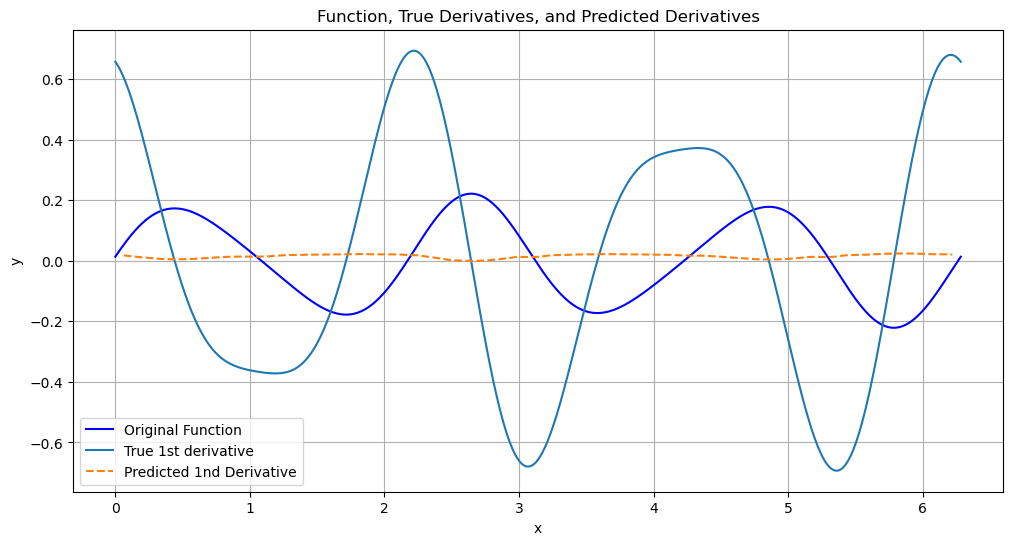

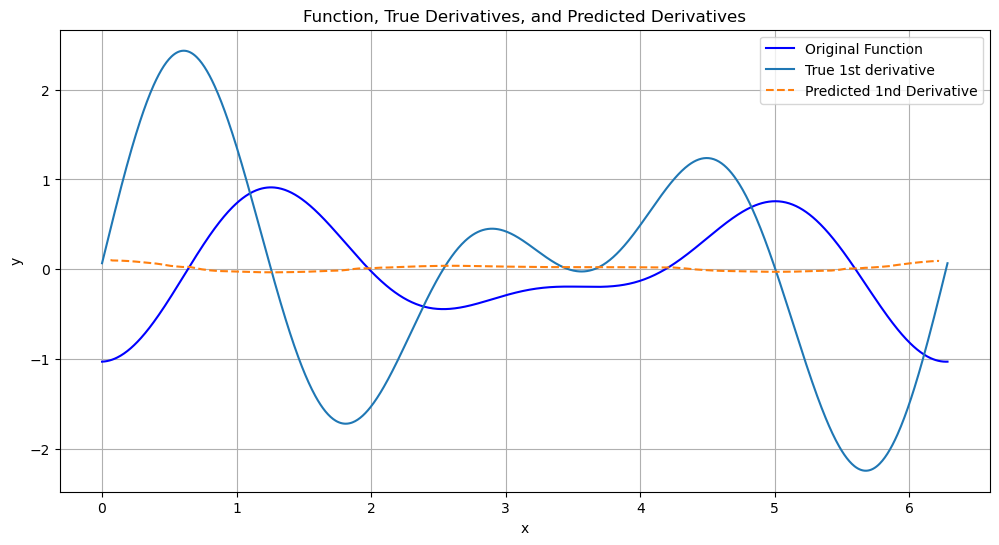

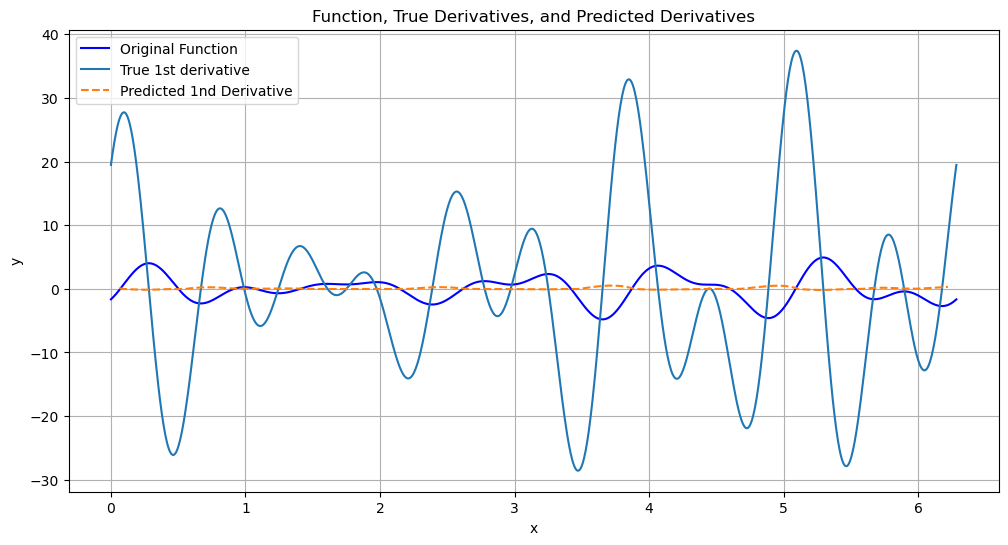

In [62]:
plot_output(L3ModelK9, dataset=train_dataset_l, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
plot_output(L3ModelK9, dataset=train_dataset_g, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)
plot_output(L3ModelK9, dataset=train_dataset_h, order=1, save_dir='../plots/spectral_bias', filename=f'{model_name}_E{num_epochs}_lf_output', save=save)

In [65]:
print_metrics(L3ModelK9)
print(L3ModelK9)

NMSE over low freq test functions: 0.9949268102645874
NMSE over general freq test functions: 0.994854211807251
NMSE over high freq test functions: 0.99500972032547
SimpleCNN(
  (convs): ModuleList(
    (0): Conv1d(1, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (1): Conv1d(64, 64, kernel_size=(9,), stride=(1,), padding=(4,))
    (2): Conv1d(64, 1, kernel_size=(9,), stride=(1,), padding=(4,))
  )
  (relu): ReLU()
  (tanh): Tanh()
)


## Trying to create the colormap

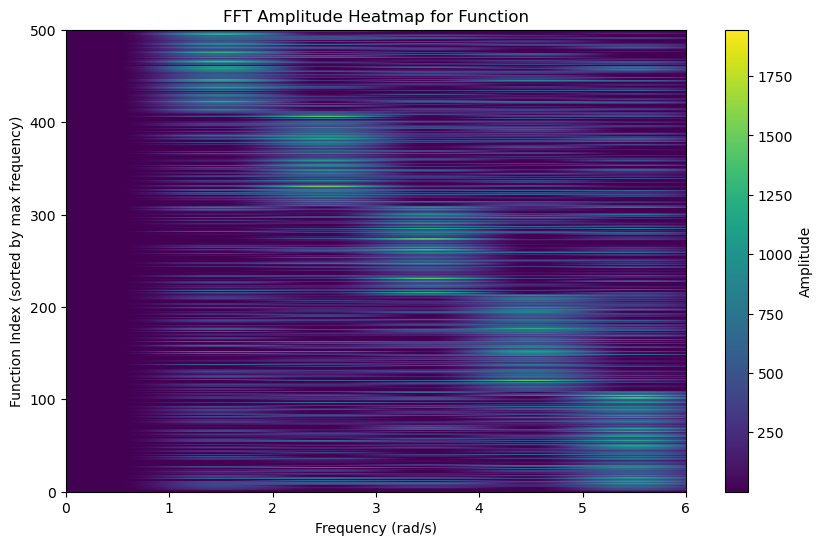

In [81]:
def compute_fft_and_max_freq(functions):
    fft_amplitudes = []
    max_frequencies = []
    n = functions.shape[1]
    freqs = np.fft.fftfreq(n, d=(2*np.pi/n))
    # freqs = freqs * (num_points / (2*np.pi))

    for function in functions:
        fft_vals = np.fft.fft(function)
        amplitudes = np.abs(fft_vals[:n//2])  # Taking only the positive frequencies
        fft_amplitudes.append(amplitudes)
        
        # Maximum frequency based on the highest amplitude
        max_freq = freqs[np.argmax(amplitudes)]
        max_frequencies.append(max_freq)
    
    return np.array(fft_amplitudes), np.array(max_frequencies), freqs[:n//2]

def plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type, xlim=1):
    freqs = freqs * 2 * np.pi
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(max_frequencies)
    sorted_fft = fft_amplitudes[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.imshow(sorted_fft, aspect='auto', extent=[freqs[0], freqs[-1], 0, len(sorted_fft)])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Frequency (rad/s)')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    plt.xlim(0, xlim)
    plt.show()

def plot_heatmap2(fft_amplitudes, max_frequencies, freqs, fun_type):
    # Convert frequencies to the original scale
    freqs_original = freqs * (2*np.pi)
    
    # Sort functions by the maximum frequency
    sorted_indices = np.argsort(max_frequencies)
    sorted_fft = fft_amplitudes[sorted_indices]
    
    plt.figure(figsize=(10, 6))
    plt.imshow(sorted_fft, aspect='auto', extent=[freqs_original[0], freqs_original[-1], 0, len(sorted_fft)])
    plt.colorbar(label='Amplitude')
    plt.xlabel('Frequency')
    plt.ylabel('Function Index (sorted by max frequency)')
    plt.title(f'FFT Amplitude Heatmap for {fun_type}')
    # plt.xlim(0, 50)  # Limit to the maximum frequency used in generation
    plt.show()


fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(low_freq_functions)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xlim=6)


In [ ]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(derivatives)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Derivatives')

In [ ]:
test_fun = low_freq_dataset[0]
# Assuming 'functions' is your array of generated functions
function = test_fun[0]  # Take the first function as an example

# Perform FFT
fft_result = np.fft.fft(function)
fft_freq = np.fft.fftfreq(len(function), 2*np.pi/len(function))

# Plot
plt.figure(figsize=(12, 6))
plt.plot(fft_freq[:len(function)//2], np.abs(fft_result)[:len(function)//2])
plt.xlabel('Frequency')
plt.ylabel('Magnitude')
plt.title('FFT of Generated Function')
plt.xlim(0, 6)  # Focus on the relevant frequency range
plt.grid(True)
plt.show()

plt.plot(function)
plt.show()


### High freq plots

In [ ]:
high_freq_dataset = HighFrequencyFourierDataset(num_samples, num_points)
functions, derivatives = high_freq_dataset.generate_data()  # Assuming generate_data() returns numpy arrays

fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq(functions)
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Function', xlim=3.3)


**Compute frequencies of model outputs**

In [ ]:
def compute_fft_and_max_freq_model(model, dataloader):
    fft_amplitudes = []
    max_frequencies = []

    model.eval()
    with torch.no_grad():
        for function_batch, _ in dataloader:  # Assuming the second item is not used
            function_batch = function_batch.unsqueeze(1)  # Add channel dimension if necessary

            # Forward pass
            output_batch = model(function_batch)
            
            # convert to numpy for FFT 
            output_batch = output_batch.squeeze().cpu().numpy()
            
            # Calculate frequency array from the first batch's output
            n = output_batch.shape[-1]
            freqs = np.fft.fftfreq(n, d=(2*np.pi/n))[:n//2]
            
            fft_vals = np.fft.fft(output_batch, axis=1)
            amplitudes = np.abs(fft_vals[:,:n//2])

            fft_amplitudes.extend(amplitudes)
            
            max_indices = np.argmax(amplitudes, axis=1)
            max_frequencies.extend(freqs[max_indices])

    return np.array(fft_amplitudes), np.array(max_frequencies), freqs

functions = LowFrequencyFourierDataset(num_samples=500, num_points=1000, max_freq=5)
dataloader = DataLoader(functions, batch_size=32, shuffle=False)

### Compute frequencies of model outputs

In [ ]:
fft_amplitudes, max_frequencies, freqs = compute_fft_and_max_freq_model(model_3L_K3, dataloader)

In [ ]:
print(compute_mse(train_dataloader_l, model_3L_K3)[0])

In [ ]:
plot_heatmap(fft_amplitudes, max_frequencies, freqs, fun_type='Model outputs')

## Updated CNN class

In [ ]:
# simple 1D CNN
class SimpleCNN(nn.Module):
    def __init__(self, n_layers=3, kernel_size=3, hidden_size=64):
        super(SimpleCNN, self).__init__()
        # Parameters
        self.n_layers = n_layers
        self.kernel_size = kernel_size
        self.hidden_size = hidden_size

        # Model
        self.convs = nn.ModuleList()
        if n_layers == 1:
            self.convs.append(nn.Conv1d(1, 1, kernel_size=kernel_size, padding=kernel_size//2))
        elif n_layers >= 2:
            self.convs.append(nn.Conv1d(1, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            for _ in range(n_layers - 2):
                self.convs.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=kernel_size, padding=kernel_size//2))
            self.convs.append(nn.Conv1d(hidden_size, 1, kernel_size=kernel_size, padding=kernel_size//2))
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()

    def forward(self, x):
        for i, conv in enumerate(self.convs):
            if i < len(self.convs):
                x = self.relu(conv(x))
            else:
                x = self.conv(x)
        return x

**For kernel size 3**

In [ ]:
set_seed(seed)

L3Model = SimpleCNN(n_layers=3, kernel_size=3)
# model = L3Model

train_losses, test_losses = model_training(L3Model, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print(f"MSE: {compute_mse(train_dataloader_g, L3Model)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3Model)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3Model)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3Model)[1]}")

**For kernel size 9**

In [ ]:
set_seed(seed)

L3ModelK10 = SimpleCNN(n_layers=3, kernel_size=9)
# model = L3Model

train_losses, test_losses = model_training(L3ModelK10, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print(f"MSE: {compute_mse(train_dataloader_g, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3ModelK10)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3ModelK10)[1]}")

**For kernel size 15**

In [ ]:
set_seed(seed)

L3ModelK10 = SimpleCNN(n_layers=3, kernel_size=15)
# model = L3Model

train_losses, test_losses = model_training(L3ModelK10, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)

In [ ]:
print(f"MSE: {compute_mse(train_dataloader_g, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_g, L3ModelK10)[1]}")

print(f"MSE: {compute_mse(train_dataloader_h, L3ModelK10)[0]}")
print(f"NMSE: {compute_mse(train_dataloader_h, L3ModelK10)[1]}")

## Linear map

In [ ]:
class SimpleLinear(nn.Module):
    def __init__(self):
        super(SimpleLinear, self).__init__()
        self.linear = nn.Linear(1000, 1000)

    def forward(self, x):
        return self.linear(x)

In [ ]:
linearMap = SimpleLinear()

train_losses, test_losses = model_training(linearMap, train_dataloader_g, test_dataloader_g,\
    num_epochs=1000, split_freq=10, filename='../plots/spectral_bias/f0_E2000_phased_training',\
    save=save, order='first')
plot_losses(train_losses, test_losses, save_dir='../plots/spectral_bias', filename='f0_E2000_phased_training', save=save)